# Draft 1 - Figure 5

__Histograms!__

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 4 as well.

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask
import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyear=1960,
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())

    dims = [i for i in obs_trends.dims if i in ["duration", "realization"]]
    availability_mask = ~np.isnan(obs_trends).any(dim=dims)
    
    _tte_bool = obs_trends > pic_trends
    _tte      = startyear + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=startyear + duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.where(availability_mask, np.nan) # Mask the unobserved regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [4]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [5]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [6]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [7]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [8]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [9]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/'
hadcrut5_dir    = 'HadCRUT5/20240820/'
obsle_dir       = 'mckinnon_OLENS/'

In [10]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [11]:
gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
gistemp_5x5_spatial_trends_filepath.sort()
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
hadcrut5_spatial_trends_filepath.sort()
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [12]:
gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.190001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.190001-202212*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [13]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data

In [14]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'realization': -1})
gistemp_5x5_spatial_trends_all['realization'] = gistemp_5x5_spatial_trends_all['realization'] - 1 # Shift back to 1
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat'})['tas'].chunk({'realization': -1})
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath).compute()

In [15]:
gistemp_regional_trends_all  = xr.open_dataarray(*gistemp_5x5_regional_trends_filepath).sel(startyear=1900).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1900).drop('startyear')
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Create masks for screening mask availability.

In [16]:
# Mask member if there are any nans
gistemp_member_availability_mask = np.isnan(gistemp_5x5_spatial_trends_all).any(dim="duration").compute()
hadcrut_member_availability_mask = np.isnan(hadcrut5_spatial_trends_all).any(dim="duration").compute()

# Mask all if all individual members are masked.
gistemp_spatial_availability_mask = gistemp_member_availability_mask.all(dim="realization")
hadcrut_spatial_availability_mask = hadcrut_member_availability_mask.all(dim="realization")

# Mask before calculating ToE
gistemp_5x5_spatial_trends_masked = gistemp_5x5_spatial_trends_all.where(~gistemp_member_availability_mask)
hadcrut5_spatial_trends_masked = hadcrut5_spatial_trends_all.where(~hadcrut_member_availability_mask)

### Compute TTE generally

In [17]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_masked,
                           'HadCRUT':hadcrut5_spatial_trends_masked}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [18]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyear=1900,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyear=1900,
            )

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='realization',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE
CPU times: user 17.3 s, sys: 3.77 s, total: 21.1 s
Wall time: 5.91 s


### Plot with IPCC Regions

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [20]:
%%time

# User set-up
data  = regional_box[0]

mean_data   = data.sel(metric='mean')
strict_data = data.sel(metric='strict')
delay_data  = data.sel(metric='delay')
delay_mask  = data.sel(metric='delay_mask')

# ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# CESM1-GISTEMP 5x5
_mean_mask   = unc_mask.copy()
_strict_mask = unc_mask.copy()
_delay_data_mask  = unc_mask.copy()
_delay_mask_mask  = unc_mask.copy()

del unc_mask

offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
for i in ipcc_ar6_regions_all.numbers:
    
    _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
    _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
    _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
    _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset

CPU times: user 2.62 s, sys: 121 ms, total: 2.74 s
Wall time: 4.17 s


### Plot histograms for regional and spatial data

Show how the resolution may influence the ToE and delay using histograms.

#### Create Combined Histogram Figure

Regional Mean fraction emerge: 0.985
Regional Strict fraction emerge: 0.971
5x5 deg. Mean fraction emerge: 0.898
5x5 deg. Strict fraction emerge: 0.834
Regional fraction delay >5years: 0.622
Regional fraction delay >10years: 0.380
Regional fraction delay >15years: 0.273
Regional fraction delay >20years: 0.198
5x5 deg. fraction delay >5years: 0.744
5x5 deg. fraction delay >10years: 0.525
5x5 deg. fraction delay >15years: 0.372
5x5 deg. fraction delay >20years: 0.281


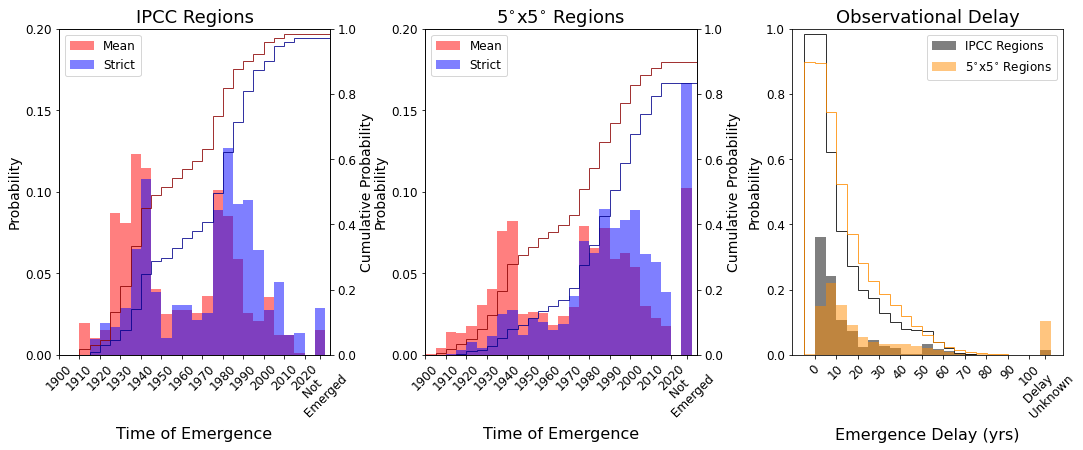

In [24]:
# Go model agnostic, but remove OBS-LE for methodological reasons.

regional_data = regional_box[0].drop_sel(model="OBS-LE") # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da.drop_sel(model="OBS-LE")
spatial_data  = spatial_masked_da.drop_sel(model="OBS-LE")

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

startyear = 1900

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon','model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.21, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
# ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.21, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)
bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
# reverse_bins = np.arange(-4.9, longest_delay - 4, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)


_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [97]:
to_png(file=fig,filename='ToE_histogram_statistics1900',dpi=300,ext='pdf',bbox_inches='tight')

Separate by model and obs.

#### Select just CESM1 and GISTEMP (for AGU)

Regional Mean fraction emerge: 1.000
Regional Strict fraction emerge: 0.989
5x5 deg. Mean fraction emerge: 0.913
5x5 deg. Strict fraction emerge: 0.844
Regional fraction delay >5years: 0.645
Regional fraction delay >10years: 0.429
Regional fraction delay >15years: 0.202
Regional fraction delay >20years: 0.068
5x5 deg. fraction delay >5years: 0.725
5x5 deg. fraction delay >10years: 0.493
5x5 deg. fraction delay >15years: 0.362
5x5 deg. fraction delay >20years: 0.276


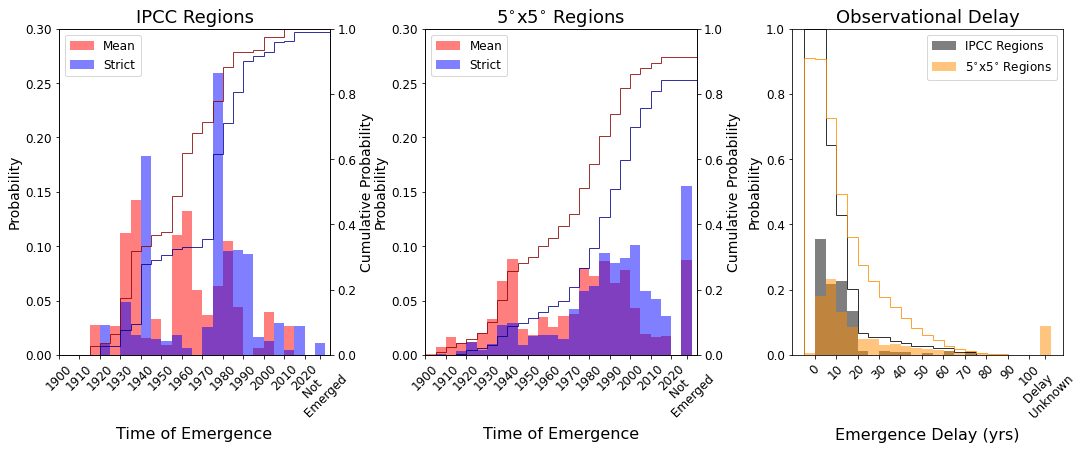

In [26]:
# Use the CESM1 vs. GISTEMP comparison
_model = 'CESM1'
_obs   = 'GISTEMP_5x5'
startyear = 1900

regional_data = regional_box[0].sel(model=_model,obs=_obs) # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da.sel(model=_model,obs=_obs)
spatial_data  = spatial_masked_da.sel(model=_model,obs=_obs)

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon',)

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
# ax.set_xlim(1967.5,2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
# xticks = np.arange(startyear, 2036, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

# bins = np.arange(0,61,5)
# reverse_bins = np.arange(0,56,5)
bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
# reverse_bins = np.arange(-4.9, longest_delay - 4, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)


_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [99]:
to_png(file=fig,filename='ToE_histogram_statistics1900_CESM1_GISTEMP',dpi=300,ext='pdf',bbox_inches='tight')

#### Mask by surface type

Just select land/ocean regions.

How to do for the spatial data? Interp like the IPCC data and then proceed?

#### Histograms for land-only

Regional Mean fraction emerge: 0.965
Regional Strict fraction emerge: 0.934
5x5 deg. Mean fraction emerge: 0.876
5x5 deg. Strict fraction emerge: 0.768
Regional fraction delay >5years: 0.618
Regional fraction delay >10years: 0.455
Regional fraction delay >15years: 0.325
Regional fraction delay >20years: 0.190
5x5 deg. fraction delay >5years: 0.657
5x5 deg. fraction delay >10years: 0.418
5x5 deg. fraction delay >15years: 0.276
5x5 deg. fraction delay >20years: 0.190


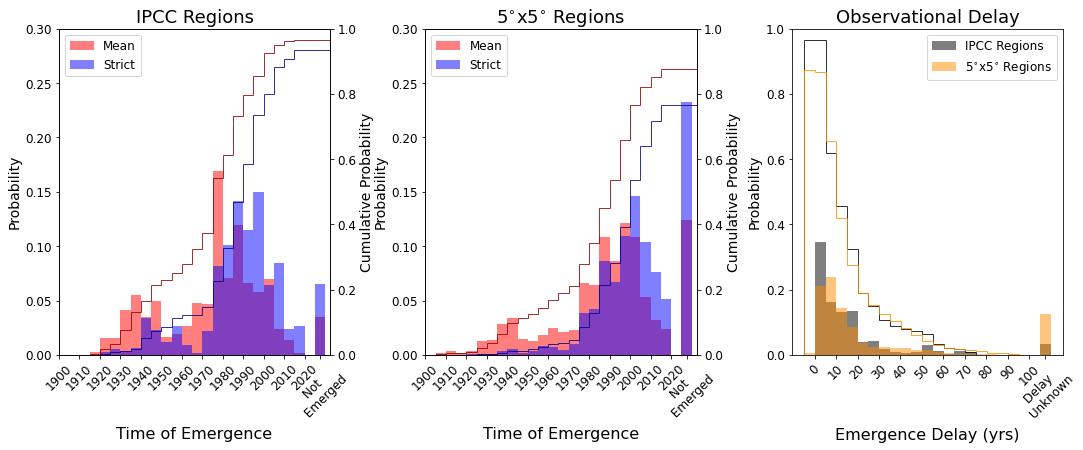

In [43]:
# Go model agnostic, but remove OBS-LE for methodological reasons.

regional_data = regional_box[0].drop_sel(model="OBS-LE") # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da.drop_sel(model="OBS-LE")
spatial_data  = spatial_masked_da.drop_sel(model="OBS-LE")

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = land #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

startyear = 1900

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon','model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
# xticks = np.arange(startyear, 2036, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(regional_data_subset.lon,regional_data_subset.lat)).broadcast_like(regional_data_subset)
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(spatial_data_subset.lon,spatial_data_subset.lat)).broadcast_like(spatial_data_subset)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [44]:
to_png(file=fig,filename='ToE_histogram_statistics1900_land',dpi=300,ext='pdf',bbox_inches='tight')

#### Histograms for ocean-only

Regional Mean fraction emerge: 0.993
Regional Strict fraction emerge: 0.987
5x5 deg. Mean fraction emerge: 0.907
5x5 deg. Strict fraction emerge: 0.862
Regional fraction delay >5years: 0.626
Regional fraction delay >10years: 0.348
Regional fraction delay >15years: 0.251
Regional fraction delay >20years: 0.202
5x5 deg. fraction delay >5years: 0.782
5x5 deg. fraction delay >10years: 0.570
5x5 deg. fraction delay >15years: 0.413
5x5 deg. fraction delay >20years: 0.319


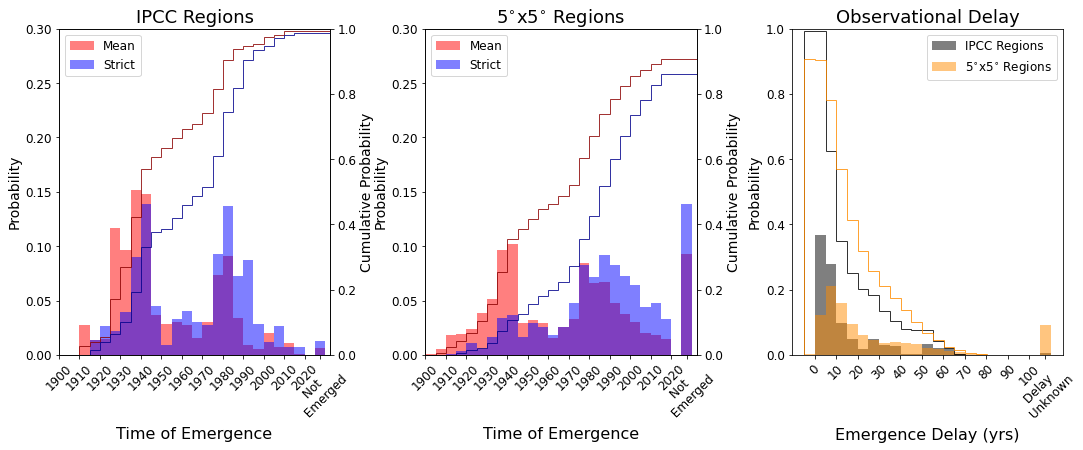

In [45]:
# Go model agnostic, but remove OBS-LE for methodological reasons.

regional_data = regional_box[0].drop_sel(model="OBS-LE") # regional data not applied to a lat-lon grid
regional_data_latloned = regional_masked_da.drop_sel(model="OBS-LE")
spatial_data  = spatial_masked_da.drop_sel(model="OBS-LE")

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = ocean #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

startyear = 1900

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon','model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
# xticks = np.arange(startyear, 2036, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Mean',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Mean ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Mean fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(regional_data_subset.lon,regional_data_subset.lat)).broadcast_like(regional_data_subset)
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(spatial_data_subset.lon,spatial_data_subset.lat)).broadcast_like(spatial_data_subset)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)


In [46]:
to_png(file=fig,filename='ToE_histogram_statistics1900_ocean',dpi=300,ext='pdf',bbox_inches='tight')